In [ ]:
# library and functions imports
import xarray as xr
import numpy as np
# interpolation function from scipy
from scipy.interpolate import interpn
# Lagrangian specific python library, see clouddrift.org
import clouddrift as cd
# dask library for parallel computing
from dask.distributed import Client, LocalCluster
import dask.array as da

In [2]:
# open local cluster
cluster = LocalCluster()
client = Client(cluster)
cluster

LocalCluster(1696ada4, 'tcp://127.0.0.1:61464', workers=8, threads=56, memory=192.00 GiB)

In [3]:
# open the hourly drifter dataset thanks to clouddrift package
ds = cd.datasets.gdp1h()
ds

/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


<xarray.Dataset>
Dimensions:                (traj: 19396, obs: 197214787)
Coordinates:
    id                     (traj) int64 ...
    time                   (obs) datetime64[ns] ...
Dimensions without coordinates: traj, obs
Data variables: (12/59)
    BuoyTypeManufacturer   (traj) |S20 ...
    BuoyTypeSensorArray    (traj) |S20 ...
    CurrentProgram         (traj) float32 ...
    DeployingCountry       (traj) |S20 ...
    DeployingShip          (traj) |S20 ...
    DeploymentComments     (traj) |S20 ...
    ...                     ...
    start_lat              (traj) float32 ...
    start_lon              (traj) float32 ...
    typebuoy               (traj) |S10 ...
    typedeath              (traj) int8 ...
    ve                     (obs) float32 ...
    vn                     (obs) float32 ...
Attributes: (12/16)
    Conventions:       CF-1.6
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    date_created:      2023-09-08T17:05:12.130123
    doi:               10.25921/x46c-3620
    ...                ...
    processing_level:  Level 2 QC by GDP drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    publisher_name:    GDP Drifter DAC
    publisher_url:     https://www.aoml.noaa.gov/phod/gdp
    summary:           Global Drifter Program hourly data
    title:             Global Drifter Program hourly drifting buoy collection

In [4]:
# select data in the same region as mur and from 2002 6 01 (beginning of mur) to 2022 10 31 (end of hourly drifter in that region I believe)
criteria_atlantic = {"lon": (-60, -50), "lat": (30, 40), "time": (np.datetime64('2002-06-01T00:00:00'), np.datetime64('2022-10-31T23:59:59'))}
# use the subset function to select the data in the region and time frame. This function is specific to clouddrift and applies to Lagrangian data
dsa = cd.ragged.subset(ds,criteria_atlantic, row_dim_name="traj", rowsize_var_name="rowsize", obs_dim_name="obs")
dsa

<xarray.Dataset>
Dimensions:                (traj: 804, obs: 1799525)
Coordinates:
    id                     (traj) int64 26656 18702 ... 300534061551870
    time                   (obs) datetime64[ns] 2002-11-24T08:00:00 ... 2022-...
Dimensions without coordinates: traj, obs
Data variables: (12/59)
    BuoyTypeManufacturer   (traj) |S20 ...
    BuoyTypeSensorArray    (traj) |S20 ...
    CurrentProgram         (traj) float32 ...
    DeployingCountry       (traj) |S20 ...
    DeployingShip          (traj) |S20 ...
    DeploymentComments     (traj) |S20 ...
    ...                     ...
    start_lat              (traj) float32 ...
    start_lon              (traj) float32 ...
    typebuoy               (traj) |S10 ...
    typedeath              (traj) int8 ...
    ve                     (obs) float32 ...
    vn                     (obs) float32 ...
Attributes: (12/16)
    Conventions:       CF-1.6
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    date_created:      2023-09-08T17:05:12.130123
    doi:               10.25921/x46c-3620
    ...                ...
    processing_level:  Level 2 QC by GDP drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    publisher_name:    GDP Drifter DAC
    publisher_url:     https://www.aoml.noaa.gov/phod/gdp
    summary:           Global Drifter Program hourly data
    title:             Global Drifter Program hourly drifting buoy collection

In [6]:
# open a zarr file with the MUR data
ds_mur = xr.open_dataset('/Volumes/Salmacis/mur/atlantic_mur_2002_2022.zarr', engine='zarr',chunks='auto')
ds_mur

/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/core/dataset.py:265: UserWarning: The specified chunks separate the stored chunks along dimension "time" starting at index 21. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/core/dataset.py:265: UserWarning: The specified chunks separate the stored chunks along dimension "lat" starting at index 893. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/core/dataset.py:265: UserWarning: The specified chunks separate the stored chunks along dimension "lon" starting at index 893. This could degrade performance. Instead, consider rechunking after loading.
  warnings.warn(


<xarray.Dataset>
Dimensions:           (time: 7458, lat: 1001, lon: 1001)
Coordinates:
  * lat               (lat) float32 30.0 30.01 30.02 30.03 ... 39.98 39.99 40.0
  * lon               (lon) float32 -60.0 -59.99 -59.98 ... -50.02 -50.01 -50.0
  * time              (time) datetime64[ns] 2002-06-01T09:00:00 ... 2022-10-3...
Data variables:
    analysed_sst      (time, lat, lon) float32 dask.array<chunksize=(25, 1001, 1001), meta=np.ndarray>
    analysis_error    (time, lat, lon) float32 dask.array<chunksize=(25, 1001, 1001), meta=np.ndarray>
    dt_1km_data       (time, lat, lon) timedelta64[ns] dask.array<chunksize=(21, 893, 893), meta=np.ndarray>
    mask              (time, lat, lon) float32 dask.array<chunksize=(25, 1001, 1001), meta=np.ndarray>
    sea_ice_fraction  (time, lat, lon) float32 dask.array<chunksize=(25, 1001, 1001), meta=np.ndarray>
    sst_anomaly       (time, lat, lon) float32 dask.array<chunksize=(25, 1001, 1001), meta=np.ndarray>
Attributes: (12/53)
    Conventions:                         CF-1.5
    Metadata_Conventions:                Unidata Observation Dataset v1.0
    acknowledgment:                      Please acknowledge the use of these ...
    build_dmrpp_metadata.bes:            3.20.13-664
    build_dmrpp_metadata.build_dmrpp:    3.20.13-664
    build_dmrpp_metadata.configuration:  \n# TheBESKeys::get_as_config()\nAll...
    ...                                  ...
    summary:                             A merged, multi-sensor L4 Foundation...
    time_coverage_end:                   20150104T210000Z
    time_coverage_start:                 20150103T210000Z
    title:                               Daily MUR SST, Final product
    uuid:                                27665bc0-d5fc-11e1-9b23-0800200c9a66
    westernmost_longitude:               -180.0

In [25]:
# nearest neighbor interpolation of the MUR data on the drifter locations
mur_sst = interpn((ds_mur.time,ds_mur.lat, ds_mur.lon), ds_mur["analysed_sst"].values, (dsa["time"],dsa["lat"], dsa["lon"]),
                    method='nearest', bounds_error=False, fill_value=np.nan)


In [58]:
# nearest neighbor interpolation of the MUR "error" data on the drifter locations
mur_sst_err = interpn((ds_mur.time,ds_mur.lat, ds_mur.lon), ds_mur["analysis_error"].values, (dsa["time"],dsa["lat"], dsa["lon"]),
                    method='nearest', bounds_error=False, fill_value=np.nan)

In [62]:
# nearest neighbor interpolation of the MUR dt_1km_data data on the drifter locations
dt_1km = interpn((ds_mur.time,ds_mur.lat, ds_mur.lon), ds_mur["dt_1km_data"].values, (dsa["time"],dsa["lat"], dsa["lon"]),
                    method='nearest', bounds_error=False, fill_value=np.nan)

/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/numpy/core/fromnumeric.py:59: RuntimeWarning: overflow encountered in multiply
  return bound(*args, **kwds)
/usr/local/Caskroom/mamba

In [63]:
# add the interpolated MUR data to the drifter dataset
dsa = dsa.assign(
    mur_sst=("obs", mur_sst),  
    mur_sst_err=("obs", mur_sst_err),
    mur_dt_1km=("obs", dt_1km)
)
dsa

<xarray.Dataset>
Dimensions:                (traj: 804, obs: 1799525)
Coordinates:
    id                     (traj) int64 26656 18702 ... 300534061551870
    time                   (obs) datetime64[ns] 2002-11-24T08:00:00 ... 2022-...
Dimensions without coordinates: traj, obs
Data variables: (12/62)
    BuoyTypeManufacturer   (traj) |S20 ...
    BuoyTypeSensorArray    (traj) |S20 ...
    CurrentProgram         (traj) float32 ...
    DeployingCountry       (traj) |S20 ...
    DeployingShip          (traj) |S20 ...
    DeploymentComments     (traj) |S20 ...
    ...                     ...
    typedeath              (traj) int8 ...
    ve                     (obs) float32 ...
    vn                     (obs) float32 ...
    mur_sst                (obs) float32 296.2 296.2 296.2 ... 296.4 296.4 296.4
    mur_sst_err            (obs) float32 0.38 0.38 0.38 0.38 ... 0.38 0.38 0.38
    mur_dt_1km             (obs) float64 -9.223e+18 -9.223e+18 ... -9.223e+18
Attributes: (12/16)
    Conventions:       CF-1.6
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    date_created:      2023-09-08T17:05:12.130123
    doi:               10.25921/x46c-3620
    ...                ...
    processing_level:  Level 2 QC by GDP drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    publisher_name:    GDP Drifter DAC
    publisher_url:     https://www.aoml.noaa.gov/phod/gdp
    summary:           Global Drifter Program hourly data
    title:             Global Drifter Program hourly drifting buoy collection

In [64]:
# save the dataset to a netcdf file
dsa.to_netcdf('gdp_atlantic.nc')

/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/codin

In [94]:
# select the data at 9am only
def select_9am(arr):
                    return (arr - arr.astype("datetime64[D]")) / np.timedelta64(1, "s") == 32400

dsa_9am = cd.ragged.subset(dsa, {"time": select_9am}, row_dim_name="traj")
dsa_9am

<xarray.Dataset>
Dimensions:                (traj: 797, obs: 74921)
Coordinates:
    id                     (traj) int64 26656 18702 ... 300534061551870
    time                   (obs) datetime64[ns] 2002-11-24T09:00:00 ... 2022-...
Dimensions without coordinates: traj, obs
Data variables: (12/62)
    BuoyTypeManufacturer   (traj) |S20 ...
    BuoyTypeSensorArray    (traj) |S20 ...
    CurrentProgram         (traj) float32 ...
    DeployingCountry       (traj) |S20 ...
    DeployingShip          (traj) |S20 ...
    DeploymentComments     (traj) |S20 ...
    ...                     ...
    typedeath              (traj) int8 ...
    ve                     (obs) float32 ...
    vn                     (obs) float32 ...
    mur_sst                (obs) float32 296.2 296.6 296.5 ... 297.6 297.3 296.7
    mur_sst_err            (obs) float32 0.38 0.37 0.37 0.38 ... 0.38 0.38 0.39
    mur_dt_1km             (obs) float64 -9.223e+18 -9.223e+18 ... -9.223e+18
Attributes: (12/16)
    Conventions:       CF-1.6
    acknowledgement:   Elipot, Shane; Sykulski, Adam; Lumpkin, Rick; Centurio...
    contributor_name:  NOAA Global Drifter Program
    contributor_role:  Data Acquisition Center
    date_created:      2023-09-08T17:05:12.130123
    doi:               10.25921/x46c-3620
    ...                ...
    processing_level:  Level 2 QC by GDP drifter DAC
    publisher_email:   aoml.dftr@noaa.gov
    publisher_name:    GDP Drifter DAC
    publisher_url:     https://www.aoml.noaa.gov/phod/gdp
    summary:           Global Drifter Program hourly data
    title:             Global Drifter Program hourly drifting buoy collection

In [96]:
# save the dataset to a netcdf file
dsa_9am.to_netcdf('gdp_9am_atlantic.nc')

/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/coding/times.py:618: RuntimeWarning: invalid value encountered in cast
  int_num = np.asarray(num, dtype=np.int64)
/usr/local/Caskroom/mambaforge/base/envs/oceanuq-tuesday/lib/python3.10/site-packages/xarray/codin

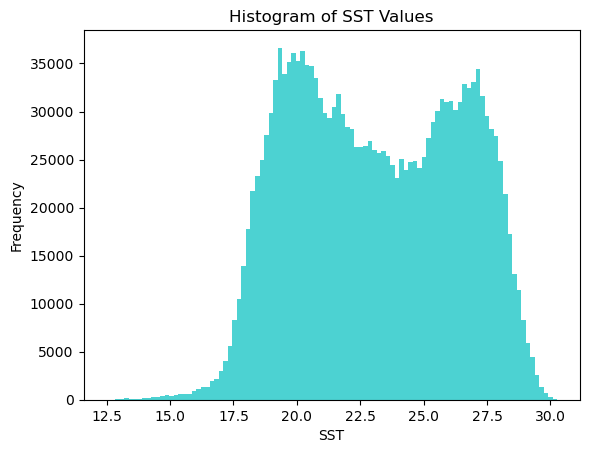

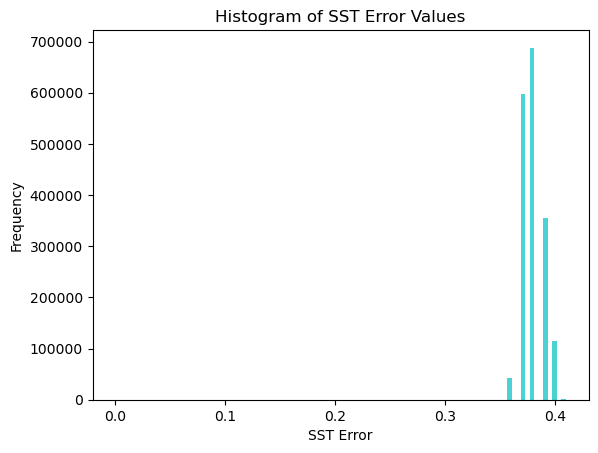

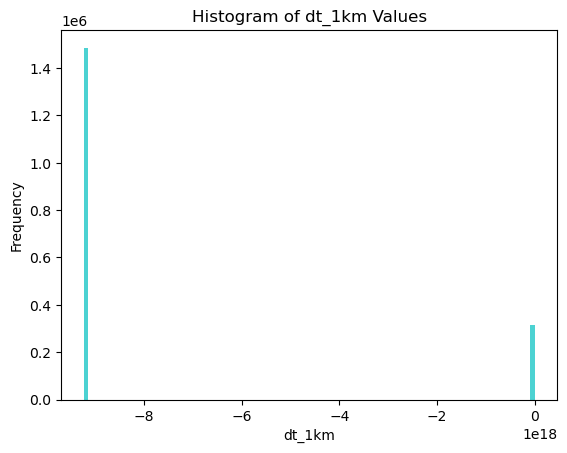

In [65]:
import matplotlib.pyplot as plt

plt.figure()
plt.hist(mur_sst-273.15, bins=100, color='c', edgecolor='none', alpha=0.7)
#plt.hist(dsa["sst"]-273.15, bins=100, color='m', edgecolor='none', alpha=0.7)
plt.xlabel('SST')
plt.ylabel('Frequency')
plt.title('Histogram of SST Values')
plt.show()

plt.figure()
plt.hist(mur_sst_err, bins=100, color='c', edgecolor='none', alpha=0.7)
plt.xlabel('SST Error')
plt.ylabel('Frequency')
plt.title('Histogram of SST Error Values')
plt.show()

plt.figure()
plt.hist(dt_1km, bins=100, color='c', edgecolor='none', alpha=0.7)
plt.xlabel('dt_1km')
plt.ylabel('Frequency')
plt.title('Histogram of dt_1km Values')
plt.show()


In [72]:
cluster.close()
client.close()